Olmo

In [ ]:
!pip install requests
HF_API_KEY = "KEY_GOES_HERE"

In [ ]:
from openai import OpenAI

HF_TOKEN = "TOKEN_GOES_HERE"

client_olmo = OpenAI(
    base_url="https://router.huggingface.co/v1",
    api_key=HF_TOKEN,
)

def query_olmo(prompt):
    completion = client_olmo.chat.completions.create(
        model="allenai/Olmo-3-7B-Instruct:publicai",
        messages=[{"role": "user", "content": prompt}],
        max_tokens=800,
        temperature=0.7,
    )
    return completion.choices[0].message.content


In [ ]:
import pandas as pd
poems_df = pd.read_csv(
    'https://github.com/maria-antoniak/poetry-eval/raw/refs/heads/main/data/poetry-evaluation_public-domain-poems.csv'
)
poems_df = poems_df[poems_df['form'].isin(['sonnet', 'ghazal'])]

sample_df = poems_df[poems_df['form'] == 'sonnet'].sample(25)
sample_df = pd.concat([sample_df, poems_df[poems_df['form'] == 'ghazal']])

In [ ]:
# Load Brown poems
import gdown
url = "https://drive.google.com/file/d/1SqTw3A99hPDbTUxZ-OoJD4wGdl0ZF3Oz/view?usp=sharing"
output = "brown_poems.csv"
gdown.download(url=url, output=output, fuzzy=True)
brown_df = pd.read_csv("brown_poems.csv")

sample_df = sample_df[['author', 'poem_title', 'poem_text', 'form']]
combined_df_olmo = pd.concat([sample_df, brown_df])

Downloading...
From: https://drive.google.com/uc?id=1SqTw3A99hPDbTUxZ-OoJD4wGdl0ZF3Oz
To: /content/brown_poems.csv
100%|██████████| 3.18k/3.18k [00:00<00:00, 4.62MB/s]


In [ ]:
# Classification template
prompt_template_start = '''
Read the following poem and classify its form as: [sonnet, ghazal, duplex].
You must choose exactly ONE.

Return the answer in this format:

1. Poetic Form: ...
2. Elaborated Rationale: ...
3. One-Word Summary: ...
4. Confidence Score: (0.0-1.0)

Poem Text:
'''

prompt_template_end = '''

Pick ONE of these forms: [sonnet, ghazal, duplex].
'''


In [ ]:
# Classification function
def extract_response_fields(response):
    """Parse Olmo's classification output"""
    lines = response.strip().split('\n')
    result = {
        'poetic_form': None,
        'rationale': None,
        'summary': None,
        'confidence': None
    }

    for line in lines:
        if line.startswith('1. Poetic Form:'):
            result['poetic_form'] = line.split(':', 1)[1].strip()
        elif line.startswith('2. Elaborated Rationale:'):
            result['rationale'] = line.split(':', 1)[1].strip()
        elif line.startswith('3. One-Word Summary:'):
            result['summary'] = line.split(':', 1)[1].strip()
        elif line.startswith('4. Confidence Score:'):
            try:
                result['confidence'] = float(line.split(':', 1)[1].strip())
            except:
                result['confidence'] = 0.0

    return result


In [ ]:
# Process poems
for index, row in combined_df_olmo.iterrows():
    prompt = prompt_template_start + row['poem_text'] + prompt_template_end
    response = query_olmo(prompt)
    fields = extract_response_fields(response)

    combined_df_olmo.at[index, 'poetic_form'] = fields['poetic_form']
    combined_df_olmo.at[index, 'rationale'] = fields['rationale']
    combined_df_olmo.at[index, 'summary'] = fields['summary']
    combined_df_olmo.at[index, 'confidence'] = fields['confidence']

combined_df_olmo.to_csv("combined_df_olmo.csv", index=False)
print(f"Classification complete. Results saved to combined_df_olmo.csv")


Classification complete. Results saved to combined_df_olmo.csv


In [ ]:
# --- Poem Generation with Olmo ---
print("\n--- Starting Olmo Poem Generation ---")

subjects = [
    "abuse", "activities", "arts & sciences", "christianity", "chronic illness",
    "crime & punishment", "cycles", "desire & passion", "doubt & contemplation",
    "family & ancestors", "gender & sexuality", "greek & roman mythology",
    "history & politics", "home life", "hope", "humor & satire",
    "indoor activities", "life choices", "lgbtq+", "living", "love",
    "love death avoidance", "memory & nostalgia", "men & women",
    "mythology & folklore", "nature", "power", "poetry & poets",
    "race & ethnicity", "relationships", "romantic love", "sexual violence",
    "sorrow & grieving", "social commentaries", "subjugation", "the mind",
    "trees and flowers", "truth", "twilight", "urban environment",
    "war & conflict", "weather", "youth"
]


--- Starting Olmo Poem Generation ---


In [ ]:
# Standard prompts
def generate_general_prompt(subject, form="Duplex"):
    return f"Write a poem about the subject of {subject} in the form: {form}."

def generate_figurative_prompt(subject, form="Duplex"):
    return f"Write a poem about {subject} using {form} techniques. Avoid using the words '{subject}' or '{form}'."

def generate_specific_prompt(subject, form="Duplex"):
    return f"Write a specific, concrete poem about {subject} following {form} conventions."


new_poems_df = pd.DataFrame(columns=['subject', 'form', 'prompt_type', 'poem_text'])


for subject in subjects:

    genPrompt = generate_general_prompt(subject)
    figPrompt = generate_figurative_prompt(subject)
    specPrompt = generate_specific_prompt(subject)

    genResponse = query_olmo(genPrompt)
    figResponse = query_olmo(figPrompt)
    specResponse = query_olmo(specPrompt)

    # Use concat (append is deprecated)
    rows = [
        {'subject': subject, 'form': 'Duplex', 'prompt_type': 'general',   'poem_text': genResponse},
        {'subject': subject, 'form': 'Duplex', 'prompt_type': 'figurative','poem_text': figResponse},
        {'subject': subject, 'form': 'Duplex', 'prompt_type': 'specific',  'poem_text': specResponse},
    ]

    new_poems_df = pd.concat([new_poems_df, pd.DataFrame(rows)], ignore_index=True)


new_poems_df.to_csv("olmo_general_poems.csv", index=False)
print("Saved olmo_general_poems.csv")


Saved olmo_general_poems.csv


In [ ]:
# Brown rules prompts
BROWN_RULES = """
Follow these strict Duplex rules:
1. Exactly 14 lines
2. 9-11 syllables per line
3. Blend sonnet, ghazal, and blues elements
4. Line 1 = Line 14
5. Line 2 reinterprets Line 1 unexpectedly
6. Line 2 = Line 3
7. Line 4 reinterprets Line 3 unexpectedly
8. Continue echo/reinterpret pattern through Line 13
9. Line 13 starts the final couplet
10. Theme: emotional tension/reflection
"""


In [ ]:
brown_df   = pd.DataFrame(columns=['subject', 'form', 'prompt_type', 'poem_text'])

In [ ]:
def generate_brown_general_prompt(subject):
    return (
        f"{BROWN_RULES}\n\n"
        f"Write a Duplex poem about the subject '{subject}'. "
        f"Follow ALL Duplex rules exactly."
    )


def generate_brown_figurative_prompt(subject):
    return (
        f"{BROWN_RULES}\n\n"
        f"Write a Duplex poem about the subject '{subject}'. "
        f"Follow ALL Duplex rules exactly. "
        f"Do NOT use the words '{subject}' or 'Duplex'."
    )


def generate_brown_specific_prompt(subject):
    return (
        f"{BROWN_RULES}\n\n"
        f"Write a very specific Duplex poem about a concrete moment, object, or memory "
        f"related to '{subject}'. Follow ALL Duplex rules exactly."
    )


brown_poems_df = pd.DataFrame(columns=['subject', 'form', 'prompt_type', 'poem_text'])


# ---- GENERATE POEMS ----
for subject in subjects:

    genPrompt = generate_brown_general_prompt(subject)
    figPrompt = generate_brown_figurative_prompt(subject)
    specPrompt = generate_brown_specific_prompt(subject)

    genResponse = query_olmo(genPrompt)
    figResponse = query_olmo(figPrompt)
    specResponse = query_olmo(specPrompt)

    # collect rows
    rows = [
        {'subject': subject, 'form': 'Duplex', 'prompt_type': 'general',   'poem_text': genResponse},
        {'subject': subject, 'form': 'Duplex', 'prompt_type': 'figurative','poem_text': figResponse},
        {'subject': subject, 'form': 'Duplex', 'prompt_type': 'specific',  'poem_text': specResponse},
    ]


    brown_poems_df = pd.concat([brown_poems_df, pd.DataFrame(rows)], ignore_index=True)


# ---- SAVE FILE ----
brown_poems_df.to_csv("olmo_brown_poems.csv", index=False)

print("\nPoem generation complete. Files saved:")
print("  - olmo_general_poems.csv")
print("  - olmo_brown_poems.csv")


Poem generation complete. Files saved:
  - olmo_general_poems.csv
  - olmo_brown_poems.csv


Olmo Determination

In [ ]:
# imports
import pandas as pd
import gdown

In [ ]:
# download human-authored poems from LK's gdrive
url = "https://drive.google.com/file/d/19RXOfv3MgMxF_f-fxwOnwhOKlbYSsERO/view?usp=drive_link"

output = "human_poems_sample.csv"

gdown.download(url=url, output=output, fuzzy=True)


Downloading...
From: https://drive.google.com/uc?id=19RXOfv3MgMxF_f-fxwOnwhOKlbYSsERO
To: /content/human_poems_sample.csv
100%|██████████| 84.2k/84.2k [00:00<00:00, 27.6MB/s]


'human_poems_sample.csv'

In [ ]:
poems_df = pd.read_csv("human_poems_sample.csv")

poems_df

poems_df['form'].value_counts(dropna=False)

,count
form,
sonnet,50
ghazal,24
blues poem,15
duplex,5


In [ ]:

prompt_template_start = '''
Read the following poem and then respond with the form of the poem based on the following verse forms: [’sonnet’, ’ghazal’, ’duplex’, 'blues poem'].
All of the poems have been tagged by experts as one of these forms. You must pick one of these options.
Please also provide an elaborated rationale for why you think the poem is in this form, a one-word summary rationale, and a score ranking your confidence in your answer from 0 to 1. Please report the single poetic form, elaborated rationale, and one-word rationale in the following format.
1. Poetic Form: Sonnet
2. Elaborated Rationale: This poem is a sonnet because...
3. One-Word Summary: Meter
4. Confidence Score : 0.73

1. Poetic Form: Ghazal
2. Elaborated Rationale: This poem is a ballad because...
3. One-Word Summary: Rhyme
4. Confidence Score : 0.91

Poem Text (in full):

'''

prompt_template_end = '''

Pick ONE of these possible verse forms: [’sonnet’, ’ghazal’, ’duplex’, 'blues poem'].
'''

In [ ]:
# import random module
import random

# generate a random number betweeen 0 and the lenght of poems_df
num = random.randint(0, len(poems_df) - 1)

# piece together the prompt
test_prompt = prompt_template_start + poems_df.iloc[num]['poem_text'] + prompt_template_end

# just take a look before we use it
print(test_prompt)


Read the following poem and then respond with the form of the poem based on the following verse forms: [’sonnet’, ’ghazal’, ’duplex’, 'blues poem'].
All of the poems have been tagged by experts as one of these forms. You must pick one of these options.
Please also provide an elaborated rationale for why you think the poem is in this form, a one-word summary rationale, and a score ranking your confidence in your answer from 0 to 1. Please report the single poetic form, elaborated rationale, and one-word rationale in the following format.
1. Poetic Form: Sonnet
2. Elaborated Rationale: This poem is a sonnet because...
3. One-Word Summary: Meter
4. Confidence Score : 0.73

1. Poetic Form: Ghazal
2. Elaborated Rationale: This poem is a ballad because...
3. One-Word Summary: Rhyme
4. Confidence Score : 0.91

Poem Text (in full):

Accuse me thus: that I have scanted all
Wherein I should your great deserts repay,
Forgot upon your dearest love to call,
Whereto all bonds do tie me day by day;


In [ ]:
from openai import OpenAI

HF_TOKEN = "TOKEN_GOES_HERE"

client_olmo = OpenAI(
    base_url="https://router.huggingface.co/v1",
    api_key=HF_TOKEN,
)

def query_olmo(prompt):
    completion = client_olmo.chat.completions.create(
        model="allenai/Olmo-3-7B-Instruct:publicai",
        messages=[{"role": "user", "content": prompt}],
        max_tokens=800,
        temperature=0.7,
    )
    return completion.choices[0].message.content


In [ ]:
# define the actual query function

def query_chatGPT (prompt):
  response = client.chat.completions.create( # Use the chat completions endpoint
    model="allenai/Olmo-3-7B-Instruct:publicai",
    messages=[
      {"role": "user", "content": prompt}, # Use messages parameter for chat models
    ],
    max_tokens=400, # up the number of tokens for a longer answer, remove additional responses below
    temperature=1
  )

  response_text = response.choices[0].message.content

  return(response_text)

In [ ]:
response = client_olmo.chat.completions.create(
  model="allenai/Olmo-3-7B-Instruct:publicai",
  messages=[
        {"role": "user", "content": test_prompt},
    ],
  max_tokens=400,
  temperature=1
)

print(response.choices[0].message.content)


1. Poetic Form: Sonnet  
2. Elaborated Rationale: This poem is a sonnet because it consists of 14 lines, follows a structured rhyme scheme (often ABAB CDCD EFEF GG in the case of a Shakespearean sonnet), and deals with themes of love, remorse, and self-reflection—common elements in the sonnet tradition. Although the provided text is brief here, the conventional structure and thematic focus align with the sonnet form among the options given.  
3. One-Word Summary: Structure  
4. Confidence Score: 0.85


In [ ]:
def extract_response_fields(response):
    """
    Extract structured fields from a response with the format:
    1. Poetic Form: ...
    2. Elaborated Rationale: ...
    3. One-Word Summary: ...
    4. Confidence Score: ...

    Args:
        response (str): The full model output string

    Returns:
        dict: Dictionary with keys 'poetic_form', 'rationale', 'summary', 'confidence'
    """
    lines = response.strip().split('\n')

    result = {
        'poetic_form': None,
        'rationale': None,
        'summary': None,
        'confidence': None
    }

    for line in lines:
        if line.startswith('1. Poetic Form:'):
            result['poetic_form'] = line.split(':', 1)[1].strip()
        elif line.startswith('2. Elaborated Rationale:'):
            result['rationale'] = line.split(':', 1)[1].strip()
        elif line.startswith('3. One-Word Summary:'):
            result['summary'] = line.split(':', 1)[1].strip()
        elif line.startswith('4. Confidence Score:'):
            result['confidence'] = line.split(':', 1)[1].strip()

    return result


# Usage:
fields = extract_response_fields(response.choices[0].message.content)
print(fields)
# Output: {'poetic_form': '...', 'rationale': '...', 'summary': '...', 'confidence': '...'}

# Access individual values:
response1 = fields['poetic_form']
response2 = fields['rationale']
response3 = fields['summary']
response4 = fields['confidence']

{'poetic_form': 'Sonnet', 'rationale': 'This poem is a sonnet because it consists of 14 lines, follows a structured rhyme scheme (often ABAB CDCD EFEF GG in the case of a Shakespearean sonnet), and deals with themes of love, remorse, and self-reflection—common elements in the sonnet tradition. Although the provided text is brief here, the conventional structure and thematic focus align with the sonnet form among the options given.', 'summary': 'Structure', 'confidence': '0.85'}


In [ ]:
for index, row in poems_df.iterrows():
    prompt = prompt_template_start + row['poem_text'] + prompt_template_end

    try:
        response = query_olmo(prompt)  # API call
        fields = extract_response_fields(response)

        poems_df.at[index, 'poetic_form'] = fields['poetic_form']
        poems_df.at[index, 'rationale'] = fields['rationale']
        poems_df.at[index, 'summary'] = fields['summary']
        poems_df.at[index, 'confidence'] = fields['confidence']

    except Exception as e:
        # Handle blocked poems gracefully
        print(f"⚠️ Skipping row {index} due to content filter block.")
        poems_df.at[index, 'poetic_form'] = 'BLOCKED'
        poems_df.at[index, 'rationale'] = ''
        poems_df.at[index, 'summary'] = ''
        poems_df.at[index, 'confidence'] = ''


⚠️ Skipping row 79 due to content filter block.


In [ ]:
poems_df['blocked'] = poems_df['poetic_form'].apply(lambda x: x == 'BLOCKED')
# Save the dataframe to a CSV file
poems_df.to_csv('olmo_poems_with_tags.csv', index=False)


In [ ]:
# replace any NaN in poems_df["poetic_form"] with "Unclassified"
poems_df['poetic_form'] = poems_df['poetic_form'].fillna('unclassified')

In [ ]:
# turn all values in poems_df["poetic_form"] to lowercase
poems_df['poetic_form'] = poems_df['poetic_form'].str.lower()
# view value counts of poems_df['poetic_form']
poems_df['poetic_form'].value_counts()

,count
poetic_form,
ghazal,61
blues poem,26
sonnet,3
duplex,3
blocked,1


In [ ]:
import re

def strip_non_letters_and_conditionally_remove_s(input_string):
    # match any non-letter character
    pattern = re.compile(r'[^a-zA-Z\s]')
    cleaned_string = pattern.sub('', input_string)

    # Remove 's' at the end of the phrase unless the phrase is "ekphrasis" or "ars poetic"
    if cleaned_string.lower().endswith('s') and not cleaned_string.lower().endswith('ekphrasis') and not cleaned_string.lower().endswith('ars poetica'):
        cleaned_string = cleaned_string[:-1]

    return cleaned_string

In [ ]:
def evaluate(row):
    # Convert columns to string type, handling potential NaN values
    form_str = str(row['form']).strip().lower()
    poetic_form_str = str(row['poetic_form']).strip().lower()

    if form_str == strip_non_letters_and_conditionally_remove_s(poetic_form_str):
        return 1
    else:
        return 0

In [ ]:
poems_df['true_correctness'] = poems_df.apply(evaluate, axis = 'columns')

poems_df

,poem_title,poem_text,author,form,poetic_form,rationale,summary,confidence,blocked,true_correctness
0,[Weaned from life and flown away],Weaned from life and flown away\nIn the mornin...,Emily Brontë,sonnet,blues poem,This poem fits the structure of a blues poem d...,Redemption,0.87,False,0
1,Of Love: A Sonnet,"How love came in I do not know,\nWhether by th...",Robert Herrick,sonnet,ghazal,This poem is a ghazal because it features a co...,Reflection,0.87,False,0
2,"Sonnet XLIV [For Thee the Sun Doth Daily Rise,...","For thee the sun doth daily rise, and set \nBe...",George Santayana,sonnet,ghazal,This poem is a ghazal because it is composed o...,Devotion,0.89,False,0
3,That you were once unkind befriends me now (So...,"That you were once unkind befriends me now,\nA...",William Shakespeare,sonnet,ghazal,This poem is a ghazal because it exhibits the ...,Reciprocity,0.85,False,0
4,Sonnet 18: Shall I compare thee to a summer’s ...,Shall I compare thee to a summer’s day?\nThou ...,William Shakespeare,sonnet,sonnet,This poem is a sonnet because it consists of 1...,Structure,0.98,False,1
...,...,...,...,...,...,...,...,...,...,...
89,Blind Boone’s Apparitions,C\n\nmy motto for life\n\n ...,Tyehimba Jess,blues poem,blues poem,This poem fits the blues poem form because it ...,Sorrow,0.88,False,1
90,Spring 1931,Northern black\nboy traveling\nwith empty bell...,Sam Cornish,blues poem,blues poem,This poem is a blues poem because it directly ...,Struggle,0.94,False,1
91,Riverbank Blues,"A man git his feet set in a sticky mudbank,\nA...",Sterling A. Brown,blues poem,blues poem,This poem is a blues poem because it exhibits ...,Lament,0.95,False,1
92,"Go Down, Death","(A Funeral Sermon)\n\nWeep not, weep not,\nShe...",James Weldon Johnson,blues poem,ghazal,This poem is a ghazal because it is composed o...,Address,0.88,False,0


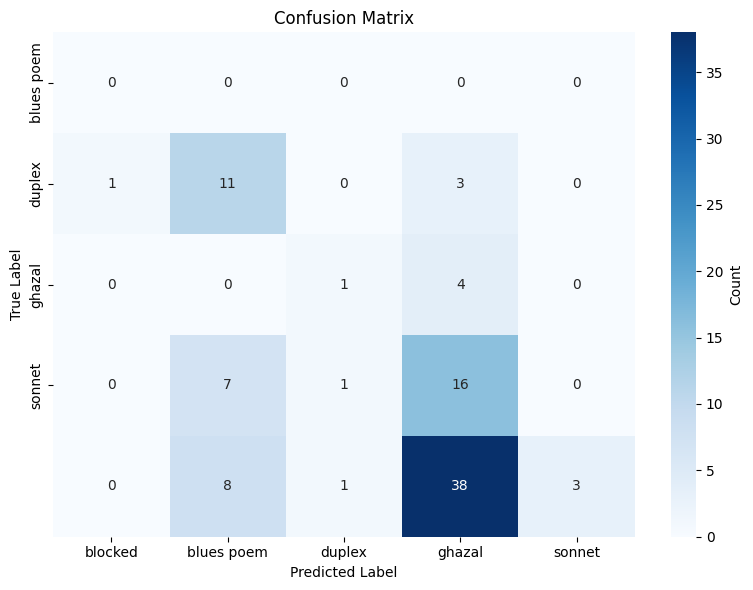

In [ ]:
# Calculate the confusion matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

df = pd.DataFrame({'y_true': poems_df['form'], 'y_pred': poems_df['poetic_form']})


cm = confusion_matrix(df['y_true'], df['y_pred'])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(df['y_pred']),
            yticklabels=np.unique(df['y_true']),
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# Using the same data
y_true = poems_df['form']
y_pred = poems_df['poetic_form']

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision and recall with different averaging methods
# 'macro' - unweighted mean (treats all classes equally)
precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)

print(f"\nMacro-averaged:")
print(f"Precision: {precision_macro:.4f}")
print(f"Recall: {recall_macro:.4f}")

# 'weighted' - weighted by support (accounts for class imbalance)
precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"\nWeighted-averaged:")
print(f"Precision: {precision_weighted:.4f}")
print(f"Recall: {recall_weighted:.4f}")

# Get detailed per-class metrics
print("\n" + "="*60)
print("Detailed Classification Report:")
print("="*60)
print(classification_report(y_true, y_pred, zero_division=0))

Accuracy: 0.3298

Macro-averaged:
Precision: 0.4037
Recall: 0.3320

Weighted-averaged:
Precision: 0.6841
Recall: 0.3298

Detailed Classification Report:
              precision    recall  f1-score   support

     blocked       0.00      0.00      0.00         0
  blues poem       0.42      0.73      0.54        15
      duplex       0.33      0.20      0.25         5
      ghazal       0.26      0.67      0.38        24
      sonnet       1.00      0.06      0.11        50

    accuracy                           0.33        94
   macro avg       0.40      0.33      0.26        94
weighted avg       0.68      0.33      0.26        94

